<a href="https://www.kaggle.com/code/sergeivolchkov/churn-prediction-catboost-logicreg?scriptVersionId=147514276" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt

# Установить 2 символа после запятой при выводе
pd.options.display.float_format = '{:,.2f}'.format

# Убрать лишние окна вывода об ошибке
import warnings
warnings.filterwarnings("ignore")

# Установить пакет для графиков функций pandas
pd.set_option('plotting.backend', 'plotly')

# Интерактивные ячейки
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import interactive

# Первая часть. Исследование

## Загрузка данных

In [2]:
df = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

# Отображение случайных строк и размерности датасета
display(df.sample(5))
display(df.shape)
display(test.shape)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4927,39,59.30,2209.15,Female,0,No,No,Yes,No,DSL,No,No,No,Yes,No,Yes,One year,No,Electronic check,0
1156,61,80.90,4932.5,Male,0,Yes,No,Yes,Yes,DSL,No,Yes,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),0
2528,28,89.90,2433.5,Female,0,Yes,No,Yes,No,Fiber optic,No,Yes,Yes,No,No,Yes,Month-to-month,No,Credit card (automatic),0
2093,6,73.85,401.3,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
229,4,42.40,146.4,Male,0,No,No,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Month-to-month,No,Mailed check,0


(5282, 20)

(1761, 19)

<div style="background-color:#f5f5f5; padding:10px">
<p>5282 строки в тренировочной выборке</p>
</div>

In [3]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = ['Churn']

Информация о train выборке

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [5]:
df.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Явных пропусков в выборках нет 

In [6]:
df.duplicated().sum()

14

Дубликаты есть - так как их мало, то дропаем их

In [7]:
df.drop_duplicates(inplace=True)

Проверим неявные пропуски

In [8]:
sys.stdout.write("Пропуски в столбцах: ")
[sys.stdout.write(f'{col} ') for col in num_cols]
sys.stdout.write("\nСоотвественно: ")
[sys.stdout.write(str(pd.to_numeric(arg=df[col], errors='coerce').isna().sum()) + ' ') for col in num_cols]
None

Пропуски в столбцах: ClientPeriod MonthlySpending TotalSpent 
Соотвественно: 0 0 9 

Изменим тип

In [9]:
df.TotalSpent = pd.to_numeric(arg=df.TotalSpent, errors='coerce')
test.TotalSpent = pd.to_numeric(arg=test.TotalSpent, errors='coerce')
df.TotalSpent.dtype

dtype('float64')

Удалим с пропущенными для тренировочной, а для тестовой заполним средним, чтобы совпадала размерность выходного файла

In [10]:
df.dropna(inplace=True)
test.fillna(0, inplace=True)
None

## Анализ данных

1) Для численных признаков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

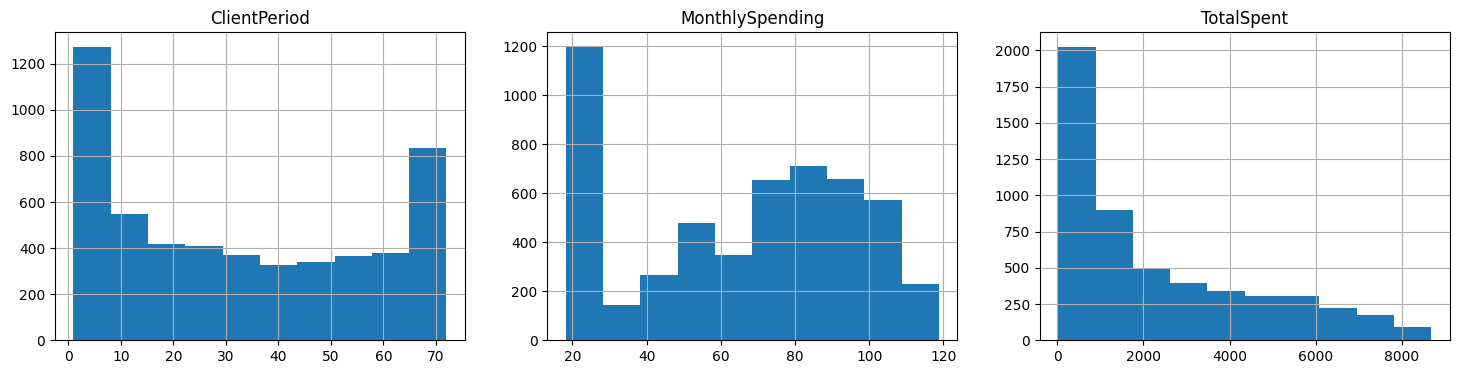

In [56]:
fig_width = len(num_cols) * 6
fig, ax = plt.subplots(1, len(num_cols), figsize=(fig_width, 4))

for i, col in enumerate(num_cols):
            ax[i].hist(df[col])
            ax[i].set_title(col)
            ax[i].grid(True)

plot_selector = widgets.Dropdown(
    options=['Гистограмма', 'Boxplot'],
    description='Выберите тип графика:',
)


def plot_graph(plot_type):
    clear_output(wait=True)
    fig_width = len(num_cols) * 6
    fig, ax = plt.subplots(1, len(num_cols), figsize=(fig_width, 4))
    if plot_type == 'Гистограмма':
        for i, col in enumerate(num_cols):
            ax[i].hist(df[col])
            ax[i].set_title(col)
            ax[i].grid(True)
    elif plot_type == 'Boxplot':
        for i, col in enumerate(num_cols):
            ax[i].boxplot(
                df[col],
                vert = False,
                showmeans = True,
                showcaps = True,
                showfliers = True,
                flierprops = dict(marker = "o", markersize = 10, markeredgecolor = "blue"),
                medianprops= dict(linestyle = "solid", linewidth = 3)
             )
            ax[i].set_title(col)
            ax[i].grid(True)

interactive_plot = interactive(plot_graph, plot_type=plot_selector)
# interactive_plot

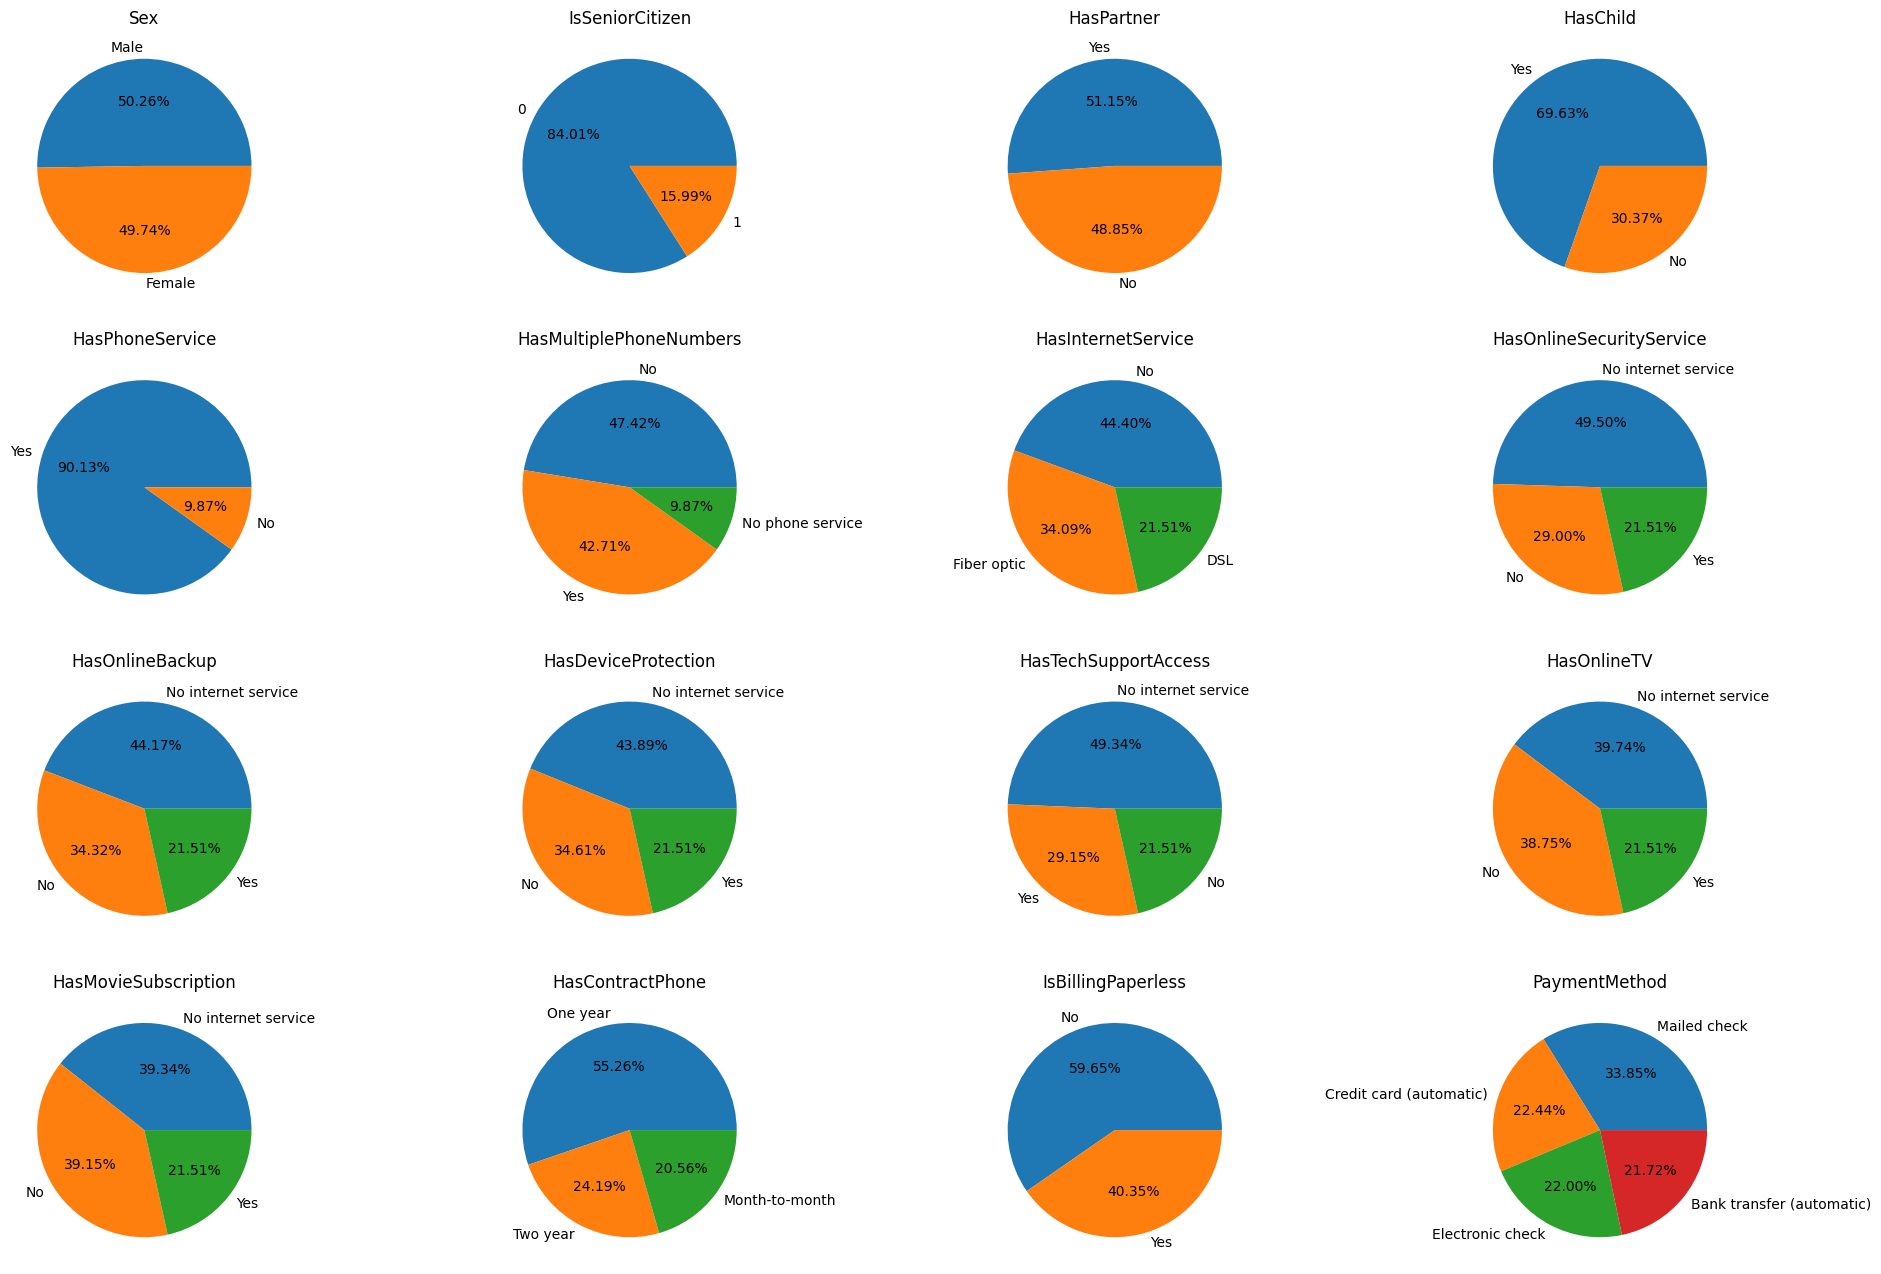

In [59]:
fig_height = len(cat_cols)/4 * 4
fig, ax = plt.subplots(int(len(cat_cols) // 4), 4, figsize=(24, fig_height))

for i, col in enumerate(cat_cols):
    ax[i // 4][i % 4].set_title(col)
    ax[i // 4][i % 4].pie(
        list(df[col].value_counts()),
        autopct='%.2f%%',
        labels=df[col].unique()
)


plot_selector = widgets.Dropdown(
    options=['Pie', 'Bar'],
    description='Выберите тип графика:',
)

# Создание функции для построения графиков
def plot_graph(plot_type):
    clear_output(wait=True)
    fig_height = len(cat_cols)/4 * 4
    fig, ax = plt.subplots(int(len(cat_cols) // 4), 4, figsize=(24, fig_height))
    
    for i, col in enumerate(cat_cols):
        ax[i // 4][i % 4].set_title(col)
        if plot_type == 'Pie':
            ax[i // 4][i % 4].pie(
                list(df[col].value_counts()),
                autopct='%.2f%%',
                labels=df[col].unique()
            )
        elif plot_type == 'Bar':
            ax[i // 4][i % 4].bar(
                df[col].value_counts().index,
                df[col].value_counts().values
            )
            ax[i // 4][i % 4].set_xticks(ax[i//4][i%4].get_xticks(), ax[i//4][i%4].get_xticklabels(), rotation=30, ha='right')
    fig.tight_layout ()

interactive_plot = interactive(plot_graph, plot_type=plot_selector)
# interactive_plot

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

In [13]:
df.Churn.value_counts()

Churn
0    3885
1    1374
Name: count, dtype: int64

In [14]:
df.Churn.value_counts()[1]/df.Churn.value_counts()[0]

0.35366795366795367

Классы являются несбалансированными, так как их распределение в выборке далеко от 1:1

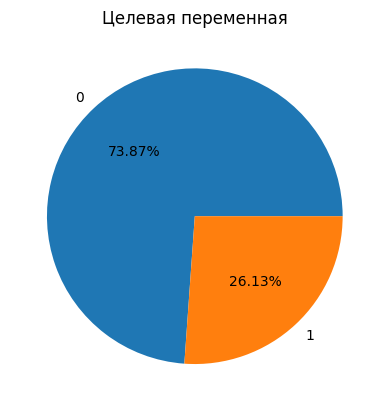

In [15]:
plt.pie(
    df.Churn.value_counts(),
    autopct='%.2f%%',
    labels=df.Churn.unique()
)
plt.title('Целевая переменная')
None

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - sns, pandas_visual_analysis, etc.

<div style="background-color:#f5f5f5; padding:10px">
<p>Буду использовать plotly</p>
</div>

In [16]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [17]:
def hist_plot_with_bar(x, title):
    return px.histogram(
        df,
        x=x,
        title=title,
        marginal='box',
        color='Churn'
    )

In [18]:
hist_plot_with_bar('ClientPeriod', 'Client period').show()
hist_plot_with_bar('MonthlySpending', 'Monthly spending').show()
hist_plot_with_bar('TotalSpent', 'Total spent').show()

In [19]:
column_selector = widgets.Dropdown(
    options=cat_cols,
    description='Выберите колонку:'
)

plot_type_selector = widgets.Dropdown(
    options=['Bar', 'Pie'],
    description='Выберите тип графика:'
)

def plot_graph(column, plot_type):
    fig = make_subplots(rows=1, cols=1)

    if plot_type == 'Bar':
        chart = go.Histogram(x=df[column])
    elif plot_type == 'Pie':
        chart = go.Pie(labels=df[column])
    
    fig.add_trace(chart)
    fig.update_layout(title_text=f'{plot_type} chart for {column}')
    fig.show()

interactive(plot_graph, column=column_selector, plot_type=plot_type_selector)

interactive(children=(Dropdown(description='Выберите колонку:', options=('Sex', 'IsSeniorCitizen', 'HasPartner…

Сохранил обработанные данные без one-hot-encoding'а

In [20]:
data_origin = df.copy()

## Применение линейных моделей

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

Резделю на целевую и остальные столбцы

In [22]:
X = df.drop(target_col, axis=1)
y = df.Churn

Разделю на train и valid выборки

In [23]:
X_train, X_val, y_train, y_val = train_test_split(df[feature_cols], df[target_col], test_size=0.33, random_state=42)

Создам pipline решенеия

In [24]:
# Применяем MinMaxScaler и OneHotEncoder для числовых и категориальных столбцов соответственно
preprocessor = ColumnTransformer(
    [
        ('Num', MinMaxScaler(), num_cols),
        ('Cat', OneHotEncoder(), cat_cols)
    ]
)

# Объединяем в единый pipline
pipeline = make_pipeline(preprocessor, LogisticRegressionCV(scoring='roc_auc', random_state=42))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Num', MinMaxScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('Cat', OneHotEncoder(),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                                                   'HasTechSupportAccess',
                                                   'HasOnlineTV',
                                                   'HasMovieSubscription',
                                                   'HasContractPhone',
                                                   'IsBillingPaperless',
                                                   'PaymentMethod'])])),
                ('logisticregressioncv',
                 LogisticRegressionCV(random_state=42, scoring='roc_auc'))])

Выведем лучшее значение гиперпараметра 

In [25]:
pipeline.named_steps['logisticregressioncv'].C_[0]

166.81005372000558

In [26]:
y_pred = pipeline.predict_proba(X_val)[:,1]

In [27]:
from sklearn.metrics import roc_auc_score

In [28]:
roc_auc_score(y_val, y_pred)

0.8304161824569987

## Применение градиентного бустинга

Разделю исходную выборку на train и valid

In [29]:
X_train, X_val, y_train, y_val = train_test_split(data_origin[feature_cols], data_origin[target_col], test_size=0.33, random_state=42)

In [30]:
from catboost import CatBoostClassifier, cv, Pool

In [31]:
# Получение индексов категориальных столбцов
inx_cat_cols = [data_origin.columns.get_loc(cat_col) for cat_col in cat_cols]
inx_cat_cols

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

Модель без указания параметров

In [32]:
model = CatBoostClassifier(
    cat_features=inx_cat_cols,
    random_seed=42,
    logging_level = 'Silent'
)

In [33]:
model.fit(X_train, y_train)

In [34]:
y_pred = model.predict_proba(X_val)[:,1]

In [35]:
roc_auc_score(y_val, y_pred)

0.825064391390922

Используем grid_search для поиска оптимальных параметров

In [36]:
model = CatBoostClassifier(
    cat_features=inx_cat_cols,
    # logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=42,
)

In [37]:
grid = {
    "max_depth": [2, 4, 8],
    "subsample": [0.1, 0.3, 0.6, 0.9],
    "n_estimators": [50, 100, 250],
    "random_strength": [1, 5, 10],
    "learning_rate": [0.05, 0.1, 0.5],
    "l2_leaf_reg": [0.1, 1., 10.],
    "min_data_in_leaf": [10, 50, 100]
}

In [38]:
model.grid_search(grid, X_train, y_train, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6696438	test: 0.6635063	best: 0.6635063 (0)	total: 3.54ms	remaining: 173ms
49:	learn: 0.8518456	test: 0.8419432	best: 0.8419432 (49)	total: 144ms	remaining: 0us

bestTest = 0.8419431998
bestIteration = 49

0:	loss: 0.8419432	best: 0.8419432 (0)	total: 155ms	remaining: 7m 30s
0:	learn: 0.6696438	test: 0.6635063	best: 0.6635063 (0)	total: 4.56ms	remaining: 223ms
49:	learn: 0.8577382	test: 0.8485399	best: 0.8485399 (49)	total: 137ms	remaining: 0us

bestTest = 0.8485399485
bestIteration = 49

1:	loss: 0.8485399	best: 0.8485399 (1)	total: 294ms	remaining: 7m 7s
0:	learn: 0.6696438	test: 0.6635063	best: 0.6635063 (0)	total: 4.14ms	remaining: 203ms
49:	learn: 0.8640097	test: 0.8486698	best: 0.8486698 (49)	total: 122ms	remaining: 0us

bestTest = 0.848669827
bestIteration = 49

2:	loss: 0.8486698	best: 0.8486698 (2)	total: 417ms	remaining: 6m 45s
0:	learn: 0.6696438	test: 0.6635063	best: 0.6635063 (0)	total: 3.61ms	remaining: 177ms
49:	learn: 0.8550888	test: 0.8485995	best: 0.848599

{'params': {'min_data_in_leaf': 10,
  'random_strength': 10,
  'depth': 2,
  'iterations': 250,
  'subsample': 0.1,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0, 249],
              'test-AUC-mean': [0.6971589531815465, 0.8541280358322212],
              'test-AUC-std': [0.030419413051534634, 0.016828336038405604],
              'train-AUC-mean': [0.6967611445050268, 0.865671030932105],
              'train-AUC-std': [0.026655606473994297, 0.003217275598490905],
              'test-Logloss-mean': [0.6533368752386218, 0.4017913868958066],
              'test-Logloss-std': [0.003486177272041408, 0.018215850862227895],
              'train-Logloss-mean': [0.6528783043863958, 0.38814347011867045],
              'train-Logloss-std': [0.003080949637218228,
               0.004146358290306229]})}

In [39]:
y_pred = model.predict_proba(X_val)[:, 1]
None

In [40]:
model.save_model("model", format="cbm")

In [41]:
roc_auc_score(y_val, y_pred)

0.8315451555247475

Кросс-валидация

In [42]:
params = {
    'loss_function': 'Logloss',
    'iterations': 80,
    'custom_loss': 'AUC',
    'random_seed': 42,
    'learning_rate': 0.5
}

cv_data = cv(
    params = params,
    pool=Pool(X_train, label=y_train, cat_features=cat_cols),
    fold_count=5,
    shuffle=True,
    plot=True,
    verbose=False,
    stratified=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.419475759
bestIteration = 13

Training on fold [1/5]

bestTest = 0.4013493348
bestIteration = 16

Training on fold [2/5]

bestTest = 0.3764362875
bestIteration = 7

Training on fold [3/5]

bestTest = 0.4392464348
bestIteration = 5

Training on fold [4/5]

bestTest = 0.4154310489
bestIteration = 6



In [43]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.50,0.01,0.50,0.01,0.79,0.02
1,1,0.45,0.01,0.44,0.01,0.82,0.02
2,2,0.44,0.02,0.42,0.01,0.82,0.02
3,3,0.42,0.02,0.41,0.01,0.83,0.02
4,4,0.42,0.02,0.39,0.00,0.84,0.02


Лучшие параметры

In [44]:
model = CatBoostClassifier(
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=42,
    l2_leaf_reg=10,
    learning_rate=0.05,
    max_depth=4,
    min_data_in_leaf=100,
    n_estimators=250,
    random_strength=5,
    subsample=0.6,
)

In [45]:
model.fit(X_train, y_train, cat_features=inx_cat_cols, eval_set=(X_val, y_val), verbose=False)

In [46]:
y_pred = model.predict_proba(X_val)[:,1]

In [47]:
roc_auc_score(y_val, y_pred)

0.831390548227283

# Предсказания

In [48]:
params = {'depth': [4],
          'random_seed': [42],
          'l2_leaf_reg': [1],
          'iterations': [200],
          'subsample': [0.5],
          'learning_rate': [0.05],
          'grow_policy': ['Lossguide']}

catboost = CatBoostClassifier(silent=True, cat_features=inx_cat_cols, eval_metric = 'AUC:hints=skip_train~false')
best_params = catboost.grid_search(params, X, y, refit=True)


bestTest = 0.842255355
bestIteration = 101

0:	loss: 0.8422554	best: 0.8422554 (0)	total: 1.6s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.8536502504
bestIteration = 153

Training on fold [1/3]

bestTest = 0.8522752946
bestIteration = 183

Training on fold [2/3]

bestTest = 0.8356004788
bestIteration = 87



In [49]:
X_test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv') # загружаем тестовую выборку
submission = pd.Series(catboost.predict_proba(X_test)[:, 1])
submission = pd.DataFrame({
    'Id': range(len(submission)),
    'Churn': submission
    })
submission.to_csv('submission.csv', index=False)

![Итог](https://i.imgur.com/ebyjKCP.png)